# B455 Final Project
# Zachary Daniels

For my final project, I wanted to create a classifier that can take in baseball data and be able to determine the type of pitch that will be thrown. For the data, I am only using pitch data for Clayton Kershaw, a pitcher for the Los Angeles Dodgers. The data was taken from https://baseballsavant.mlb.com/statcast_search. He throws four pitches, 4-seam fastball (FF), slider (SL), curve (CU), and changeup (CH). I used data from Kershaw's 2011 and 2019 seasons and compared the results of classification between seasons. The first part of the project uses two models, one for the 2011 data and one for the 2019 data. These models try and classify the exact pitch type that will be thrown. The second part of the project uses one model for both seasons of data, and is a binary classifier that tries to determine whether a fastball or offspeed/breaking pitch will be thrown. For all of the models used I created them using Keras libraries and then used a sklearn wrapper to enable their use with sklearn's learning curve functions.

The first module loads in all the necessary libraries and data from csv files. The stats variable holds the column names of all the attributes I wanted to use during the project. In total, each of the models uses 8 inputs.

    Balls
    Strikes
    Flag for a runner on 3rd base
    Flag for a runner on 2nd base
    Flag for a runner on 1st base
    Number of outs
    Inning
    Relative Score: calculated by Dodgers' score - opponent's score

The clean_data function takes in the dataframes and trims and creates target arrays for pitch types. 

In [1]:
import pandas as pd
import numpy as np
import keras
import sklearn
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics
import matplotlib.pyplot as plt


stats = ['pitch_type', 'zone', 'balls', 'strikes', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning',
         'bat_score', 'fld_score']
bases = ['on_3b', 'on_2b', 'on_1b']
pitches = ['CH','CU','FF','SL']
zones = [i for i in range(1,15)]
kersh2011 = pd.read_csv("kershaw2011.csv")
kersh2019 = pd.read_csv("kershaw2019.csv")

def clean_data(df):
    df.dropna(subset=['pitch_type'], inplace=True)
    df = df[df.pitch_type.isin(['CH','CU','FF','SL'])]
    df = df[stats].fillna(0)
    for base in bases:
        df.loc[df[base] > 0, base] = 1
    df['score'] = df['fld_score'] - df['bat_score']
    pitch_targets = np.asarray(df['pitch_type'])
    zone_targets = np.asarray(df['zone'])
    df = df.drop(columns=['pitch_type', 'zone','bat_score', 'fld_score'])
    df = np.asarray(df)
    return df, pitch_targets, zone_targets

kersh2011, pitch_targets_2011, zone_targets_2011 = clean_data(kersh2011)
kersh2019, pitch_targets_2019, zone_targets_2019 = clean_data(kersh2019)

Using TensorFlow backend.


The following code shows the difference in pitch counts between the 2011 and 2019 season. When Kershaw was younger, he was able to throw harder and longer, allowing him to throw more fastballs and more pitches over the course of a season. In 2019, he has a changed approach to pitching which causes him to throw more offspeed pitches but also limits him to fewer pitches thrown each game. This leads to a large difference in the amount of pitches and data available for each season. Even with the disparity of data between the groups, 2019 still contains over 2000 instances of pitches. Looking at the amount of pitch types being thrown, it's easily seen that the changeup and curveball pitches would be harder to learn with fewer availability, which is the reason why I included a model that trains on binary classification of fastball vs offspeed/breaking (CH, CU, SL).

In [2]:
uni, count = np.unique(pitch_targets_2011, return_counts=True)
pitch_rec_2011 = dict(zip(uni, count))
uni, count = np.unique(pitch_targets_2019, return_counts=True)
pitch_rec_2019 = dict(zip(uni, count))
print("2011: ", pitch_rec_2011)
print("2019: ", pitch_rec_2019)

2011:  {'CH': 120, 'CU': 184, 'FF': 2255, 'SL': 895}
2019:  {'CH': 16, 'CU': 425, 'FF': 1130, 'SL': 1006}


Here is where the first two models are setup. The first model for 2011 ended up being a single hidden layer MLP. The single hidden layer contains 128 nodes, with the output layer containing 4 nodes for each pitch type and a softmax activation. It uses Adam for optimization and categorical cross entropy for the loss function. This first model was kept simplistic to avoid overfitting. The 2019 model is more complex, with 5 hidden layers of increasing size, (32, 64, 128, 256, 512). The only other difference between the models was the number of epochs, with the 2011 model having 25 and 2019 having 50.

In [3]:
kFold = StratifiedKFold(shuffle=True)
sc = StandardScaler()
enc = LabelEncoder()

def mlpModel2011():
    mlp = Sequential()
    mlp.add(Dense(8, activation='relu'))
    mlp.add(Dense(128, activation='relu'))
    mlp.add(Dense(4, activation='softmax'))
    mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return mlp

def mlpModel2019():
    mlp = Sequential()
    mlp.add(Dense(8, activation='relu'))
    mlp.add(Dense(32, activation='relu'))
    mlp.add(Dense(64, activation='relu'))
    mlp.add(Dense(128, activation='relu'))
    mlp.add(Dense(256, activation='relu'))
    mlp.add(Dense(512, activation='relu'))
    mlp.add(Dense(4, activation='softmax'))
    mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return mlp

model2011 = KerasClassifier(build_fn=mlpModel2011, epochs=25, verbose=0)
model2019 = KerasClassifier(build_fn=mlpModel2019, epochs=50, verbose=0)

For Kershaw's 2011 season the model was able to learn his pitch types high above what a random baseline model would. Multiple iterations of training and testing had the model always ending with validation accuracy around 68%-71%. The model uses 5 fold cross validation with shuffling to ensure the accuracy and training samples would be different each time. From the learning curve graph it can be seen that the training and validation curves are beginning to flatten out but are still a small distance from each other. As stated earlier, this model was kept simplistic to avoid overfitting, which occurred often in early testing. At this point, the model is trained to a good generalization standpoint and could perform similarly if given more data from 2019 Kershaw.

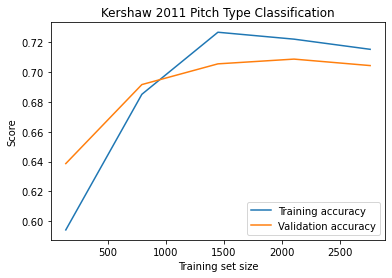

Average Training Accuracy 0.6887073519995723
Average Validation Accuracy 0.6898123702258856


In [4]:
X_11 = sc.fit_transform(kersh2011)
y_11 = enc.fit_transform(pitch_targets_2011)
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
    model2011, X_11, y_11, train_sizes=np.linspace(.05, 1.0, 5), scoring='accuracy', cv=kFold, return_times=True)
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)
plt.plot(train_sizes, train_mean, label = 'Training accuracy')
plt.plot(train_sizes, test_mean, label = 'Validation accuracy')
plt.ylabel('Score')
plt.xlabel('Training set size')
plt.title('Kershaw 2011 Pitch Type Classification')
plt.legend()
plt.show()
print("Average Training Accuracy", train_mean.mean())
print("Average Validation Accuracy", test_mean.mean())

The 2019 season proved to be very difficult to classify. Even with a more complex model the validation accuracy always ended up around 50%. Still better than a baseline model would produce, but very far from how the 2011 model performed on its own data. Looking at the learning curve you can see that the curves flatten out over the last two training set sizes. I could only conclude that Kershaw's 2019 season was very difficult to classify on a general basis. A main reason for this could stem from the fact that the way Kershaw pitches is different from 2011. As he has gotten older, he has had to rely on surprising the batter and not following a specific pattern of pitches. In 2011, it was much easier to classify the pitches because as a young and healthy player, Kershaw was able to beat batters by strength of his pitches. He could throw a few more MPH harder on his fastballs, and his offspeed and breaking pitches had more movement to them. Therefore even if batters had a good idea of what pitch was coming, it was still incredibly difficult to hit.

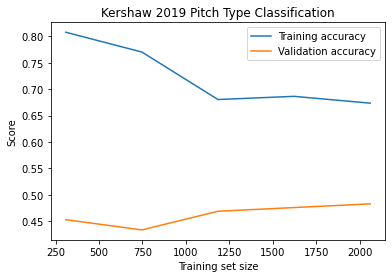

Average Training Accuracy 0.7236456788260643
Average Validation Accuracy 0.46269963121848423


In [5]:
X_19 = sc.fit_transform(kersh2019)
y_19 = enc.fit_transform(pitch_targets_2019)
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
    model2019, X_19, y_19, train_sizes=np.linspace(.15, 1.0, 5), scoring='accuracy', cv=kFold, return_times=True)
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)
plt.plot(train_sizes, train_mean, label = 'Training accuracy')
plt.plot(train_sizes, test_mean, label = 'Validation accuracy')
plt.ylabel('Score')
plt.xlabel('Training set size')
plt.title('Kershaw 2019 Pitch Type Classification')
plt.legend()
plt.show()
print("Average Training Accuracy", train_mean.mean())
print("Average Validation Accuracy", test_mean.mean())

Here I attempted to have each model try and predict the pitch types from the other season. Both usually performed at about 50% accuracy on predicting the pitches. This goes along with the previous conclusions that pointed to the changes in Kershaw's pitching habits. As pitcher with 8 seasons of experience, there would still be some overlap in pitch style which is a reason why the models still reach 50% instead of lower. The fact that the 2019 model performed very similarly on both of the datasets shows that it was generalized to the best of its ability based on its training data.

In [6]:
model2011.fit(X_11, y_11)
model2019.fit(X_19, y_19)
print("2011 Model Prediction Accuracy for 2019 data: ", metrics.accuracy_score(y_19, model2011.predict(X_19)))
print("2019 Model Prediction Accuracy for 2011 data: ", metrics.accuracy_score(y_11, model2019.predict(X_11)))

2011 Model Prediction Accuracy for 2019 data:  0.48855258051998446
2019 Model Prediction Accuracy for 2011 data:  0.49305153445280836


In this final part of the project, I looked at the classification of fastball vs offspeed/breaking pitches. I used the same model for both seasons, which contains 2 hidden layers with 64 and 128 nodes. The output layer contains a single node with a sigmoid activation function. It uses a loss function of binary cross entropy and has 10 epochs. This module also creates new target arrays that change all the offspeed pitches to OS. With the binary classification, I expected to see large increases in accuracy by this model, as the majority of pitchers follow trends of when they throw offspeed vs fastballs.

In [7]:
def mlpPitchType():
    mlp = Sequential()
    mlp.add(Dense(8, activation='relu'))
    mlp.add(Dense(64, activation='relu'))
    mlp.add(Dense(128, activation='relu'))
    mlp.add(Dense(1, activation='sigmoid'))
    mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return mlp

pitchModel = KerasClassifier(build_fn=mlpPitchType, epochs=10, verbose=0)
offspeed = ['CH', 'CU', 'SL']
two_pitch_2011 = pitch_targets_2011.copy()
two_pitch_2019 = pitch_targets_2019.copy()
for pitch in offspeed:
    two_pitch_2011[two_pitch_2011 == pitch] = 'OS'
    two_pitch_2019[two_pitch_2019 == pitch] = 'OS'

For 2011 data, the model did not perform as high as I thought it would. It still outperformed the previous multiclass model, but only by a few percent. Even so, a 72% accuracy is a sign of a well trained model. In baseball, having 70% accuracy in knowing what pitch is coming would be incredibly helpful. And this model also follows the same logic as the previous 2011 model, that Kershaw was able confidently throw pitches that might be expected because of his skill as a pitcher during that year.

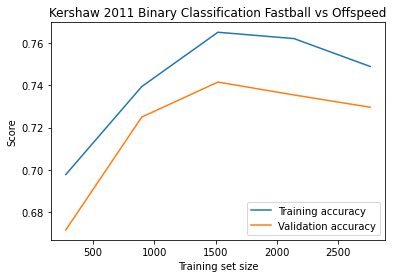

Average Training Accuracy 0.7425921142025032
Average Validation Accuracy 0.720614106839489


In [8]:
y_11_two = enc.fit_transform(two_pitch_2011)
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
    pitchModel, X_11, y_11_two, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy', cv=kFold, return_times=True)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)
plt.plot(train_sizes, train_mean, label = 'Training accuracy')
plt.plot(train_sizes, test_mean, label = 'Validation accuracy')
plt.ylabel('Score')
plt.xlabel('Training set size')
plt.title('Kershaw 2011 Binary Classification Fastball vs Offspeed')
plt.legend()
plt.show()

print("Average Training Accuracy", train_mean.mean())
print("Average Validation Accuracy", test_mean.mean())

The 2019 model did improve to an accuracy that I expected. It was able to score about 14% higher compared to its multiclass model and improved almost 10% more than the 2011 binary classifier. The fact that it had a much higher improvement most likely goes back to the pitch count numbers earlier in the project. When separated into fastballs and offspeed/breaking pitches, the 2019 data was much more even between pitch types than 2011's data. While Kershaw during the 2019 season relied on his ability to surprise the batter, there was a larger difference between whether he threw fastball or offspeed than what specific offspeed pitch he threw, compared to 2011's data.  

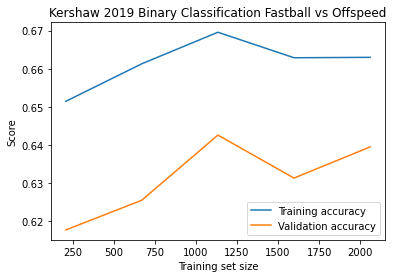

Average Training Accuracy 0.6616277385293158
Average Validation Accuracy 0.6313619327161887


In [9]:
y_19_two = enc.fit_transform(two_pitch_2019)
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
    pitchModel, X_19, y_19_two, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy', cv=kFold, return_times=True)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)
plt.plot(train_sizes, train_mean, label = 'Training accuracy')
plt.plot(train_sizes, test_mean, label = 'Validation accuracy')
plt.ylabel('Score')
plt.xlabel('Training set size')
plt.title('Kershaw 2019 Binary Classification Fastball vs Offspeed')
plt.legend()
plt.show()

print("Average Training Accuracy", train_mean.mean())
print("Average Validation Accuracy", test_mean.mean())

Overall, the models for this project actually underperformed my expectations. After seeing the results however, it's clear that Kershaw's reputation as a top pitcher is partly because of his ability to mix up his pitch selection and refrain from following a clear cut pattern. Not only that, but it's easy to see that he has changed as a pitcher from 2011 to 2019. The data clearly follows what has been reported about Kershaw, that as he has gotten older, he has had to focus on using more offspeed pitches to keep hitters off balance and unsure of what he will throw next. As his career goes on and he gets older, I expect that this trend will continue to the point where he throws even more offspeed pitches than fastballs, using pitches like his changeup and curveball more often to go with his slider. 